# Ridge Regression Model

This notebook contains a basic Ridge regression with GridSearch and a pipeline with parameters. 

You will see the data cleaning, exploratory data analysis (EDA), preporcessing, modeling, and lastly evulation to submit to the Kaggle Competition. 

*Ridge Regression will be referred to as 'Ridge' or 'ridge' throughout the text

# DataFrame Imports

In [1]:
#First import the Libraries & tools needed to comeplete the Ridge Regression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer


In [2]:
training = pd.read_csv('/Users/khalildavis/Desktop/General Assembly Work/Submissions/Projects/Project 2 Final Submits/Data Sets/train.csv')
training.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [3]:
testing = pd.read_csv('/Users/khalildavis/Desktop/General Assembly Work/Submissions/Projects/Project 2 Final Submits/Data Sets/test.csv')
testing.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [4]:
sample_sub = pd.read_csv('/Users/khalildavis/Desktop/General Assembly Work/Submissions/Projects/Project 2 Final Submits/Data Sets/sample_sub_reg_origin.csv')
sample_sub.head(2)

,Id,SalePrice
0,2,181479.1217
1,4,181479.1217


# EDA

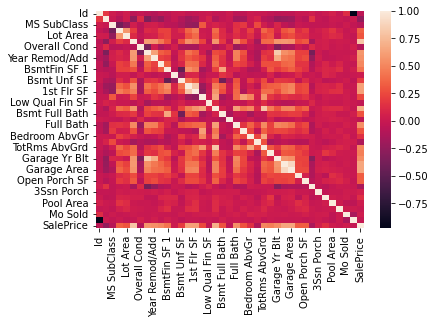

In [5]:
#See correlation model of the training set to help choose with features to try in the model
sns.heatmap(training.corr());

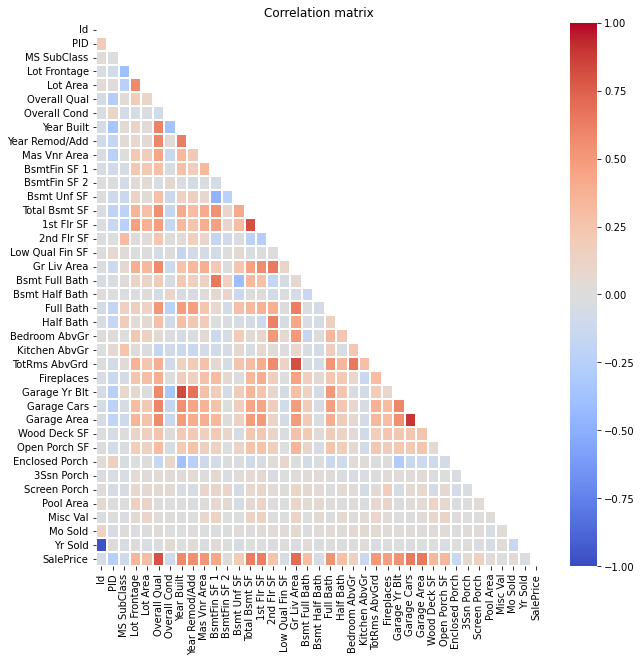

In [6]:
#Create a correlation Matrix for the features, to have a better view.

mask = np.zeros_like(training.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))
sns.heatmap(
    training.corr(),
    cmap='coolwarm',
    annot=False,
    mask=mask,
    vmin=-1.,
    vmax=1.,
    linewidths=.1,
    center=0
)

plt.title('Correlation matrix'); 

Once I have choosen the features I would like to use, I start to prepare for the Train_Test_Split by stating my X and y.

In [7]:
X = training[['Lot Area','Overall Qual', 'BsmtFin SF 1', 'Bsmt Unf SF', 'Total Bsmt SF',
'1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath',   
'Full Bath', 'Half Bath', 'Bedroom AbvGr',  
'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF','Open Porch SF',         
'Screen Porch'
]]

y = training['SalePrice'] 

In [8]:
#Performed tts
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=444)

# Data Cleaning & Preprocessing

To clean the data to use within the tts, I will be using Simple Imputer to help filling in missing data cells within the training and testing data sets. 

Since its a basic Ridge with GridSearch, I have choosen the strategy='mean' because majority of the features I am starting with a numeric. If the features were catergorical, I would have choosen strategy='most_frequent' aka the mode. 

In [9]:
#Imported SimpleImputer to fill missive values by 'mean'
#Instantiating the Simpe Imputer

si = SimpleImputer(strategy='mean')

In [10]:
#Fit & transform Simple Imputer to the training data

X_train_filled = si.fit_transform(X_train)
X_train_filled

array([[1.2929e+04, 6.0000e+00, 6.9700e+02, ..., 3.6000e+01, 8.2000e+01,
        0.0000e+00],
       [2.5440e+03, 7.0000e+00, 3.6800e+02, ..., 0.0000e+00, 1.7200e+02,
        0.0000e+00],
       [9.1700e+03, 5.0000e+00, 6.9800e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.1512e+04, 6.0000e+00, 7.1900e+02, ..., 0.0000e+00, 0.0000e+00,
        1.6300e+02],
       [3.3630e+03, 7.0000e+00, 0.0000e+00, ..., 0.0000e+00, 4.0000e+01,
        0.0000e+00],
       [1.0800e+04, 5.0000e+00, 1.2000e+03, ..., 1.2000e+02, 0.0000e+00,
        0.0000e+00]])

In [11]:
#Create a new data frame to keep the changes that have been made with the training and testing set.

X_train_filled = pd.DataFrame(X_train_filled, columns=X_train.columns)

In [12]:
#Checking to see all rows and columns are filled
X_train_filled.isna().sum()

Lot Area          0
Overall Qual      0
BsmtFin SF 1      0
Bsmt Unf SF       0
Total Bsmt SF     0
1st Flr SF        0
2nd Flr SF        0
Gr Liv Area       0
Bsmt Full Bath    0
Full Bath         0
Half Bath         0
Bedroom AbvGr     0
TotRms AbvGrd     0
Fireplaces        0
Garage Cars       0
Garage Area       0
Wood Deck SF      0
Open Porch SF     0
Screen Porch      0
dtype: int64

In [13]:
#This is great to follow my steps with the pipe and gridsearch.

from sklearn import set_config
set_config(display='diagram')

In [14]:
#Making a pipeline to scale the data while creating polynomial features

pipe3 = make_pipeline(
PolynomialFeatures(),
StandardScaler(),
Ridge()

)

pipe3

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()), ('ridge', Ridge())])

When it comes to Ridge you must set parameters to help determine the coefficients. Lastly, using an range of alphas that the model can iterate through to determine what are the best features and parameters to have a succesful model

In [15]:
params3 = {
'polynomialfeatures__interaction_only': [True, False],
'ridge__alpha': [0.01, .1, 1, 10, 100]

}

In [16]:
#Decided to add GridSearCV to really have the best chance of creating an efficient model

gs3 = GridSearchCV(pipe3, params3, n_jobs=-1)

In [17]:
#Fitting the gridsearch to the traning data
gs3.fit(X_train_filled, y_train)

GridSearchCV(estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__interaction_only': [True, False],
                         'ridge__alpha': [0.01, 0.1, 1, 10, 100]})

In [18]:
##Putting my cv_results into a data frame
#Then taking a look at the rank, mean test score, alphas and parameters to see which model did the best

pd.DataFrame(gs3.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomialfeatures__interaction_only,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025772,0.002866,0.005926,0.001913,True,0.01,"{'polynomialfeatures__interaction_only': True,...",0.897604,0.880905,0.851359,0.782763,0.323246,0.747175,0.215569,6
1,0.026007,0.004881,0.005718,0.001860,True,0.1,"{'polynomialfeatures__interaction_only': True,...",0.900528,0.887073,0.857533,0.782627,0.330231,0.751598,0.214601,5
2,0.020763,0.002338,0.007102,0.003675,True,1,"{'polynomialfeatures__interaction_only': True,...",0.904036,0.892249,0.861861,0.789506,0.344846,0.758499,0.210629,4
3,0.017685,0.001467,0.005101,0.000274,True,10,"{'polynomialfeatures__interaction_only': True,...",0.907396,0.894994,0.869127,0.841490,0.345377,0.771677,0.214350,3
4,0.018594,0.002611,0.004399,0.000573,True,100,"{'polynomialfeatures__interaction_only': True,...",0.899520,0.897178,0.861439,0.889317,0.392087,0.787908,0.198374,1
5,0.020844,0.000732,0.004535,0.000525,False,0.01,{'polynomialfeatures__interaction_only': False...,0.881298,0.849783,0.846820,0.829922,0.104254,0.702415,0.299541,10
6,0.020943,0.001599,0.006150,0.001746,False,0.1,{'polynomialfeatures__interaction_only': False...,0.886064,0.861070,0.859496,0.833344,0.135789,0.715153,0.290161,9
7,0.017610,0.001134,0.004475,0.000726,False,1,{'polynomialfeatures__interaction_only': False...,0.893762,0.880355,0.861989,0.830959,0.188906,0.731194,0.271961,8
8,0.017929,0.001667,0.004523,0.000650,False,10,{'polynomialfeatures__interaction_only': False...,0.903082,0.893106,0.866669,0.815992,0.249936,0.745757,0.249742,7
9,0.014639,0.001678,0.002597,0.000457,False,100,{'polynomialfeatures__interaction_only': False...,0.899975,0.898430,0.863454,0.880360,0.357216,0.779887,0.211756,2


In [19]:
##Getting the best parameters from the GridSearch
gs3.best_params_

{'polynomialfeatures__interaction_only': True, 'ridge__alpha': 100}

In [20]:
gs3.score(X_train_filled, y_train)

0.902641581942592

In [21]:
gs3.score(X_test, y_test)

0.8401081350088313

In [22]:
gs3_preds = gs3.predict(testing[['Lot Area','Overall Qual', 'BsmtFin SF 1', 'Bsmt Unf SF', 'Total Bsmt SF',
'1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath',   
'Full Bath', 'Half Bath', 'Bedroom AbvGr',  
'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF','Open Porch SF',         
'Screen Porch']])

gs3_preds

array([165241.36385579, 171484.70836393, 197378.10722653, 110790.81076313,
       186962.62906431,  87257.74178404,  93499.52708591, 137190.38550289,
       174262.30187737, 174841.49362813, 152711.56993318, 129480.74176853,
       157391.68707929, 298299.77628505, 156644.81644641, 112234.48137755,
       187167.26620015, 118738.12995196, 211459.44830684, 217909.27963402,
       126270.73801893, 156527.46108445, 197799.37579855, 194919.40670782,
       179030.34770893, 107582.76784813, 119036.7414736 , 118427.67023844,
       151519.01184764,  61236.71698107,  97025.52253636,  96597.0293337 ,
       273396.90647537, 153318.84318699, 203997.50523032, 164509.08434542,
       116100.27995511,  85745.80440935, 103914.75389282, 189629.57733723,
       145051.14775028, 210384.98962648, 133759.74124724, 157424.24825412,
       227096.68753936,  87954.26236549, 212943.11169083, 121404.87301086,
       111351.05043875, 134079.69552398, 115946.02080289, 212402.99588312,
       257316.03404721, 1

**Evaluation**
Using ridge was able to cut down the the error down to $26,800 to reduce variation and try to prevent overfitting. Using the ridge 100, was able to shrink coefficients.

In [23]:
testing['SalePrice'] = gs3_preds

In [24]:
testing[['Id', 'SalePrice']]

,Id,SalePrice
0,2658,165241.363856
1,2718,171484.708364
2,2414,197378.107227
3,1989,110790.810763
4,625,186962.629064
...,...,...
873,1662,205704.166960
874,1234,203524.700058
875,1373,122124.074175
876,1672,104729.680949


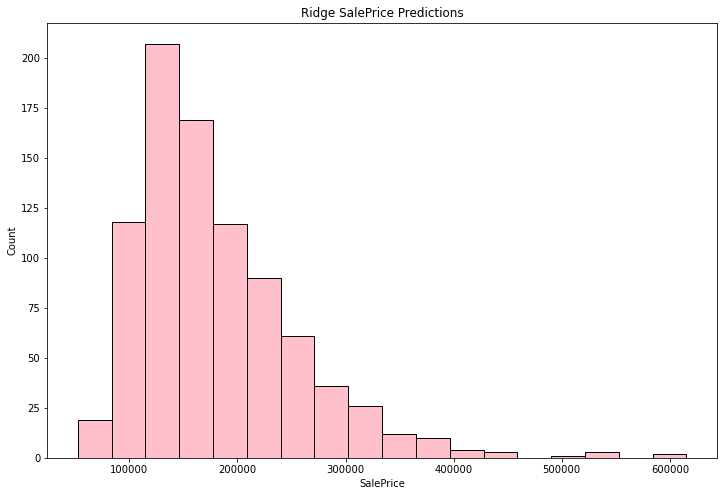

In [25]:
plt.figure(figsize = (12, 8))   

plt.hist(testing['SalePrice'], color ='pink', bins=18, ec = 'black');

plt.title('Ridge SalePrice Predictions');
plt.xlabel('SalePrice')
plt.ylabel('Count');

In [26]:
#Submission #26835.94051
testing[['Id', 'SalePrice']].to_csv('Gs_pipe3_Ridge.5F.csv', index=False)